# Analysis of Data from All-Russian Population Surveys Obtained as a Part of the Monitoring the Status of the Civil Society at the NRU HSE

### The aim of the project is to try to predict values missing from the survey results.

In [72]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.svm import SVR

from sklearn.tree import ExtraTreeRegressor
from sklearn.ensemble import BaggingRegressor

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV


In [105]:
import warnings
warnings.filterwarnings('ignore')

In [64]:
# Input file with data is stored locally, as it is prohibited to share the data.
df = pd.read_excel('883_ИМД-2.xlsx', sheet_name='Values')

In [4]:
df.head(5)

,ID,REGION,FO,Q1010,S1,S2,S3,S3_AGE,S4,Q1,...,D6,D6_DR,D7,D7_DR,D8,D8_DR,D9,D10,D10_DR,D11
0,Идентификатор респондента,Region. Отметьте Ваш регион,FO. Федеральный округ,Место опроса,"S1. Тип населённого пункта, где живёт респондент",S2. Пол респондента,"S3. Скажите, пожалуйста, сколько лет Вам испол...",(Запишите) (лет),S4. Какое у Вас образование?,"Q1. Как Вы считаете, большинству людей можно д...",...,"D6. В какой отрасли Вы работаете, какова сфера...",Другое (уточните),D7. Членом или сторонником какой политической ...,Другое (уточнить),D8. Считаете ли Вы себя верующим человеком? И ...,Другое (уточнить ),D9. Какое место занимает религия в Вашей жизни?,D10. В чём выражается Ваша принадлежность к ве...,Другое (уточнить ),D11. Как Вы оцениваете состояние своего здоровья?
1,063a20a33e679b4,25,8,130,8,1,5,70,4,1,...,NaN,NaN,97,NaN,97,NaN,NaN,NaN,NaN,3
2,06539b004760a54,64,5,82,8,1,5,71,2,1,...,NaN,NaN,97,NaN,97,NaN,NaN,NaN,NaN,4
3,06e85272a3a11d4,5,4,62,5,2,3,44,6,2,...,4,NaN,97,NaN,3,NaN,1,5,NaN,3
4,06470c0967c0d24,59,5,72,3,1,3,43,4,2,...,1,NaN,97,NaN,1,NaN,99,99,NaN,2


In [65]:
# Exclude header data as it is not needed
df = df.drop(0)

In [66]:
# Exclude identification column, as it is not needed in the research and also can affectconfidentiality of data
df = df.drop('ID', axis=1)

In [67]:
# Convert datatypes as they are all string 
df = df.convert_dtypes()
df = df.select_dtypes(include='number')

In [56]:
df.head(5)

,REGION,FO,Q1010,S1,S2,S3,S3_AGE,S4,Q1,Q2,...,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11
1,25,8,130,8,1,5,70,4,1,1,...,1,4,<NA>,<NA>,<NA>,97,97,<NA>,<NA>,3
2,64,5,82,8,1,5,71,2,1,1,...,99,4,<NA>,<NA>,<NA>,97,97,<NA>,<NA>,4
3,5,4,62,5,2,3,44,6,2,2,...,3,1,3,<NA>,4,97,3,1,5,3
4,59,5,72,3,1,3,43,4,2,2,...,4,1,1,5,1,97,1,99,99,2
5,55,7,110,1,1,1,23,2,1,1,...,1,2,<NA>,<NA>,<NA>,97,99,4,99,2


Text(0.5, 0, 'Age')

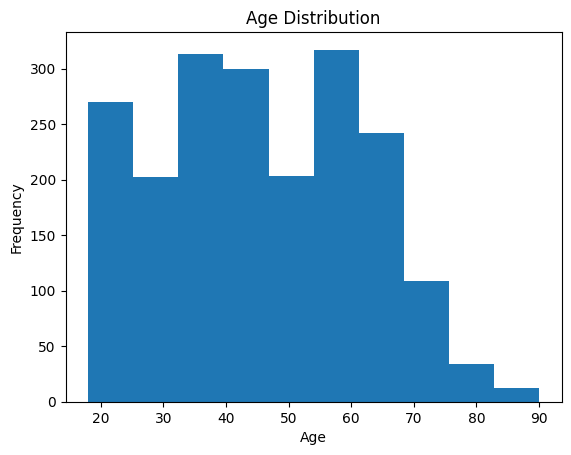

In [38]:
df['S3_AGE'].plot(kind='hist')
plt.title('Age Distribution')
plt.xlabel('Age')


Text(0.5, 0, 'Federal_Region_Code')

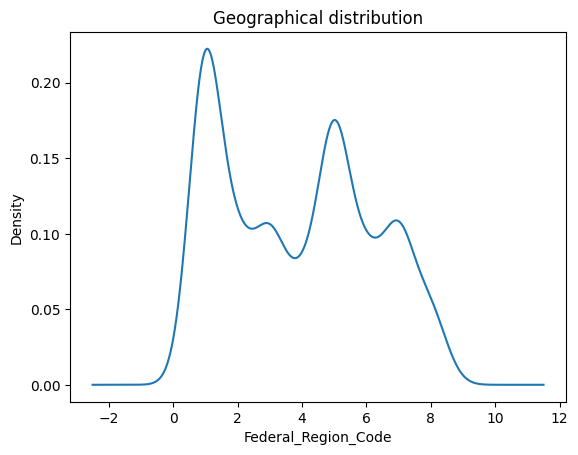

In [39]:
df['FO'].plot(kind='kde')
plt.title('Geographical distribution')
plt.xlabel('Federal_Region_Code')

### Graphs above indicate that citizens surveyed where from different age and territory areas, meaning that results contain many possible clusters of people.

In [68]:
# All answers coded as 99 are "Затрудняюсь ответить/отказ от ответа" or similarly phrased ones, which means it is still unknown.
# Thus, such values should be predicted as well.

df.replace(99, np.nan, inplace=True)

### There are many of columns present in the dataset, but it is important to find the ones that have missing/broken data and filter them

In [57]:
df.columns

Index(['REGION', 'FO', 'Q1010', 'S1', 'S2', 'S3', 'S3_AGE', 'S4', 'Q1', 'Q2',
       ...
       'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11'],
      dtype='object', length=475)

### When we find amount of missing values for particular question it is important to acknowledge that some questions have just missing values, but some of the questions have mutually exclusive answers. For example, "AGE" column can contain value or the answer could be missing, however "Q13" can be missing if "Q12" has been answered with certain option (97)

In [71]:
# Find amounts of blank values for each question

nan_counts = df.isna().sum()
nan_columns_dict = nan_counts[nan_counts == 0].to_dict()

print(len(nan_columns_dict))
nan_columns_dict

357


{'REGION': 0,
 'FO': 0,
 'S1': 0,
 'S2': 0,
 'S3': 0,
 'S3_AGE': 0,
 'S4': 0,
 'Q7_1': 0,
 'Q7_2': 0,
 'Q7_3': 0,
 'Q7_4': 0,
 'Q7_5': 0,
 'Q7_6': 0,
 'Q7_7': 0,
 'Q7_8': 0,
 'Q7_9': 0,
 'Q7_10': 0,
 'Q7_11': 0,
 'Q7_12': 0,
 'Q7_13': 0,
 'Q7_14': 0,
 'Q7_15': 0,
 'Q7_16': 0,
 'Q7_17': 0,
 'Q7_18': 0,
 'Q7_19': 0,
 'Q7_20': 0,
 'Q7_21': 0,
 'Q7_22': 0,
 'Q7_23': 0,
 'Q7_24': 0,
 'Q7_25': 0,
 'Q7_26': 0,
 'Q7_97': 0,
 'Q7_98': 0,
 'Q7_99': 0,
 'Q9_1': 0,
 'Q9_2': 0,
 'Q9_3': 0,
 'Q9_4': 0,
 'Q9_5': 0,
 'Q9_6': 0,
 'Q9_7': 0,
 'Q9_8': 0,
 'Q9_9': 0,
 'Q9_10': 0,
 'Q9_11': 0,
 'Q9_12': 0,
 'Q9_13': 0,
 'Q9_14': 0,
 'Q9_15': 0,
 'Q9_16': 0,
 'Q9_17': 0,
 'Q9_18': 0,
 'Q9_19': 0,
 'Q9_20': 0,
 'Q9_21': 0,
 'Q9_22': 0,
 'Q9_23': 0,
 'Q9_24': 0,
 'Q9_25': 0,
 'Q9_26': 0,
 'Q9_97': 0,
 'Q9_98': 0,
 'Q9_99': 0,
 'Q10_1': 0,
 'Q10_2': 0,
 'Q10_3': 0,
 'Q10_4': 0,
 'Q10_5': 0,
 'Q10_6': 0,
 'Q10_7': 0,
 'Q10_8': 0,
 'Q10_9': 0,
 'Q10_10': 0,
 'Q10_11': 0,
 'Q10_12': 0,
 'Q10_13': 0,
 'Q10_14': 0,

### We aim to use columns that are completely filled as X, while having columns with incomplete answers as Y. Y values are chosen based on the number of missing values and importance of the question in the survey.
### icols correspond to X, jcols to Y. jcols are chosen based on number of missing values and importance of the corresponding questions.

Q4 - А если говорить о людях, которые окружают лично Вас, среди них сегодня больше согласия, сплоченности или несогласия, разобщённости?

Q5 - Есть люди, готовые объединяться с другими людьми для каких-либо совместных действий, если их идеи и интересы совпадают. И есть люди, не готовые объединяться с другими для совместных действий, даже если их идеи и интересы совпадают. К кому Вы отнесли бы себя — к первым или ко вторым?

Q6 - Если не говорить о семье и ближайших родственниках, за последний год, Вам приходилось или не приходилось оказывать по собственной инициативе помощь кому-либо, совершать поступки на благо других людей, заниматься благотворительностью?

D1 - Какое высказывание точнее всего описывает материальное положение Вашей семьи? 

D2 - Какая примерно часть доходов вашей семьи уходит сейчас на питание?

D4 - Скажите, на основной своей работе Вы работаете по найму или Вы предприниматель либо самозанятый(-ая)? 

In [74]:
icols = [x for x in nan_columns_dict]
jcols = ['Q4','Q5','Q6', 'D1','D2','D4']
nan_counts = df[jcols].isna().sum()
nan_columns_dict = nan_counts[nan_counts > 0].to_dict()

nan_columns_dict

{'Q4': 101, 'Q5': 87, 'Q6': 19, 'D1': 111, 'D2': 98, 'D4': 715}

### We will try to train on all known values, and uknown values can be predicted with any of methods mentioned below. This allows future readers to select strategy of choice, by comparing accuracy scores and methods used, to utilize best suitable one. In order to fill the blank values, the trained model just needs to be fed with missing data.

In [75]:
from sklearn.model_selection import train_test_split

notnans = df[jcols].notnull().all(axis=1)
df_notnans = df[notnans]


X_train, X_test, y_train, y_test = train_test_split(df_notnans[icols], df_notnans[jcols],
                                                    train_size=0.85,
                                                    random_state=42)


Here the are some models tested. Of course other many models were used (from sklearn), however some of the possible solutions yielded bad results (accuracy scores < 5%), so they were not included. It is understanable that some models are applicable for exact case, so there is no wonder that some of them did not work.

### Here are some models with permutations of some parameters. Best parameters are extracted based on the score computed for each set of parameters. These are results for exact dataset, however it can shift with the change of data.

In [90]:
from sklearn.ensemble import RandomForestRegressor

parameters = {
    'max_depth':[x for x in range(1, 30, 3)],
    'min_samples_split': [x for x in range(2, 10, 2)]
}

regr_multirf = RandomForestRegressor(random_state = 42, n_estimators = 300, n_jobs=16)

clf = GridSearchCV(regr_multirf, parameters, cv=3)

# Fit on the train data
clf.fit(X_train, y_train)

# Check the prediction score
score = clf.score(X_test, y_test)
print("The prediction score on the test data is {:.2f}%".format(score*100))

print(clf.best_params_)

The prediction score on the test data is 29.66%
{'max_depth': 22, 'min_samples_split': 2}


In [94]:
from sklearn.ensemble import HistGradientBoostingRegressor

parameters = {
    'estimator__learning_rate':[x / 100 for x in range(10, 50, 5)],
    'estimator__min_samples_leaf':[x for x in range(15, 30, 2)]
}

regr_multirf = HistGradientBoostingRegressor(random_state = 42)

clf = GridSearchCV(MultiOutputRegressor(regr_multirf), param_grid=parameters, cv=3)

# Fit on the train data
clf.fit(X_train, y_train)

# Check the prediction score
score = clf.score(X_test, y_test)
print("The prediction score on the test data is {:.2f}%".format(score*100))

print(clf.best_params_)

The prediction score on the test data is 28.05%
{'estimator__learning_rate': 0.1, 'estimator__min_samples_leaf': 15}


In [100]:
from sklearn.ensemble import GradientBoostingRegressor

parameters = {
    'estimator__learning_rate':[x / 100 for x in range(10, 50, 7)],
    'estimator__n_estimators':[x for x in range(100, 200, 50)]
}

regr_multirf = GradientBoostingRegressor(random_state = 42)

clf = GridSearchCV(MultiOutputRegressor(regr_multirf), param_grid=parameters, cv=3)

# Fit on the train data
clf.fit(X_train, y_train)

# Check the prediction score
score = clf.score(X_test, y_test)
print("The prediction score on the test data is {:.2f}%".format(score*100))

print(clf.best_params_)

The prediction score on the test data is 20.82%
{'estimator__learning_rate': 0.1, 'estimator__n_estimators': 150}


In [104]:
from sklearn.svm import SVR

#C=10, epsilon=0.25

parameters = {
    'estimator__epsilon':[x / 100 for x in range(10, 50, 5)],
    'estimator__C':[x for x in range(1, 16, 2)],
    'estimator__tol':[x / 1000 for x in range(10, 100, 20)]
}


regr_multirf = SVR()


clf = GridSearchCV(MultiOutputRegressor(regr_multirf), param_grid=parameters, cv=3)

# Fit on the train data
clf.fit(X_train, y_train)

# Check the prediction score
score = clf.score(X_test, y_test)
print("The prediction score on the test data is {:.2f}%".format(score*100))

print(clf.best_params_)

The prediction score on the test data is 8.75%
{'estimator__C': 15, 'estimator__epsilon': 0.2, 'estimator__tol': 0.05}


In [31]:
from sklearn.tree import ExtraTreeRegressor

extra_tree = ExtraTreeRegressor(random_state=42)

reg = BaggingRegressor(extra_tree, random_state=42)

regr_multirf = MultiOutputRegressor(reg)

# Fit on the train data
regr_multirf.fit(X_train, y_train)

# Check the prediction score
score = regr_multirf.score(X_test, y_test)
print("The prediction score on the test data is {:.2f}%".format(score*100))

The prediction score on the test data is 19.61%


### Another way to fill in the gaps is imputating. It is a different approach that also can be used, so instructions for using it are also presented. There are many types of imputation that utilize different methods. Unlike the the models, imputation is working only in vertical manner, meaning that each column is considered isolated from others. In the given research problem such method can probably even yield good results, but the nature of said approach is not suitable.

In [51]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan, strategy='median')
imputed_train_data = imp.fit_transform(df)


imputed_train_data = pd.DataFrame(imputed_train_data).astype(int)
imputed_train_data.columns = df.columns
imputed_train_data.index = df.index

imputed_train_data
# Computing mean is redundant, the method itself is mean

,REGION,FO,Q1010,S1,S2,S3,S3_AGE,S4,Q1,Q2,...,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11
1,25,8,130,8,1,5,70,4,1,1,...,1,4,1,4,4,97,97,2,1,3
2,64,5,82,8,1,5,71,2,1,1,...,2,4,1,4,4,97,97,2,1,4
3,5,4,62,5,2,3,44,6,2,2,...,3,1,3,4,4,97,3,1,5,3
4,59,5,72,3,1,3,43,4,2,2,...,4,1,1,5,1,97,1,2,1,2
5,55,7,110,1,1,1,23,2,1,1,...,1,2,1,4,4,97,1,4,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1998,68,1,26,3,1,4,47,4,2,2,...,3,1,1,5,3,1,1,2,1,3
1999,24,7,120,3,1,5,66,2,2,1,...,3,4,1,4,4,97,97,2,1,4
2000,43,5,74,2,2,4,50,4,2,2,...,3,1,2,4,5,97,97,2,1,3
2001,26,4,59,8,1,4,54,4,2,2,...,1,3,1,4,98,97,97,2,1,2


In [108]:
from sklearn.impute import KNNImputer

imp = KNNImputer(n_neighbors=2, weights="uniform")
imputed_train_data = imp.fit_transform(df)


imputed_train_data = pd.DataFrame(imputed_train_data).astype(int)
imputed_train_data.columns = df.columns
imputed_train_data.index = df.index

imputed_train_data

,REGION,FO,Q1010,S1,S2,S3,S3_AGE,S4,Q1,Q2,...,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11
1,25,8,130,8,1,5,70,4,1,1,...,1,4,1,3,3,97,97,2,1,3
2,64,5,82,8,1,5,71,2,1,1,...,3,4,1,5,1,97,97,2,1,4
3,5,4,62,5,2,3,44,6,2,2,...,3,1,3,3,4,97,3,1,5,3
4,59,5,72,3,1,3,43,4,2,2,...,4,1,1,5,1,97,1,3,1,2
5,55,7,110,1,1,1,23,2,1,1,...,1,2,1,3,11,97,49,4,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1998,68,1,26,3,1,4,47,4,2,2,...,3,1,1,5,3,1,1,2,1,3
1999,24,7,120,3,1,5,66,2,2,1,...,3,4,1,3,3,97,97,2,1,4
2000,43,5,74,2,2,4,50,4,2,2,...,3,1,2,3,5,97,97,3,1,3
2001,26,4,59,8,1,4,54,4,2,2,...,1,3,1,3,98,97,97,3,1,2


In [107]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


imp = IterativeImputer(max_iter=3, random_state=0, tol=0.1)
imputed_train_data = imp.fit_transform(df)


imputed_train_data = pd.DataFrame(imputed_train_data).astype(int)
imputed_train_data.columns = df.columns
imputed_train_data.index = df.index

imputed_train_data

,REGION,FO,Q1010,S1,S2,S3,S3_AGE,S4,Q1,Q2,...,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11
1,25,8,130,8,1,5,70,4,1,1,...,1,4,1,4,1,97,97,2,15,3
2,64,5,82,8,1,5,71,2,1,1,...,2,4,0,4,15,97,97,1,41,4
3,5,4,62,5,2,3,44,6,2,2,...,3,1,3,4,4,97,3,1,5,3
4,59,5,72,3,1,3,43,4,2,2,...,4,1,1,5,1,97,1,3,10,2
5,55,7,110,1,1,1,23,2,1,1,...,1,2,1,4,12,97,66,4,19,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1998,68,1,26,3,1,4,47,4,2,2,...,3,1,1,5,3,1,1,2,1,3
1999,24,7,120,3,1,5,66,2,2,1,...,3,4,0,4,13,97,97,3,25,4
2000,43,5,74,2,2,4,50,4,2,2,...,3,1,2,4,5,97,97,2,19,3
2001,26,4,59,8,1,4,54,4,2,2,...,1,3,1,4,98,97,97,2,24,2


# Conclusion

### There are many various ways to substitute missing values in given data. With sufficient amount of training data, one could expect to have models with quite high performance scores. Also, some other constraints or changes could be done to the questionary itself, in order to give clearer results. Additionally, methods described here could be used to complete values in other surveys or similar content, which can allow for forming of complete picture describing the status of civil society in Russia.